In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/labelme/IMG_4017.jpg
/kaggle/input/labelme/IMG_3896.jpg
/kaggle/input/labelme/IMG_2872.jpg
/kaggle/input/labelme/IMG_3200.json
/kaggle/input/labelme/IMG_4020.jpg
/kaggle/input/labelme/IMG_3780.json
/kaggle/input/labelme/IMG_3347.jpg
/kaggle/input/labelme/IMG_3347.json
/kaggle/input/labelme/IMG_2829.json
/kaggle/input/labelme/IMG_3683.jpg
/kaggle/input/labelme/IMG_3047.json
/kaggle/input/labelme/IMG_4017.json
/kaggle/input/labelme/IMG_3780.jpg
/kaggle/input/labelme/IMG_4020.json
/kaggle/input/labelme/IMG_2850.jpg
/kaggle/input/labelme/IMG_2872.json
/kaggle/input/labelme/IMG_3047.jpg
/kaggle/input/labelme/IMG_3200.jpg
/kaggle/input/labelme/IMG_3896.json
/kaggle/input/labelme/IMG_2829.jpg
/kaggle/input/labelme/IMG_3683.json
/kaggle/input/labelme/IMG_2850.json
/kaggle/input/silk-dataset/silk_dataset/IMG_3946.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_2771.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3912.jpg
/kaggle/input/silk-dataset/silk_dataset/IMG_3167.jpg
/kaggle

In [18]:
import os
import random
import shutil
import time
import statistics
from pathlib import Path
from typing import List, Tuple
import torchvision.transforms as T
import json
import numpy as np
import torch
import cv2
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import matplotlib.patches as mpatches
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from transformers import get_cosine_schedule_with_warmup

# --- Configuration ---
# Directory where LabelMe saved your JSON annotation files (and where original images are located)
LABELME_OUTPUT_DIR = '/kaggle/input/labelme' # <--- UPDATE THIS PATH!
# Directory where the converted PNG masks will be saved
OUTPUT_MASKS_DIR = '/kaggle/working/output_masks_png' # <--- UPDATE THIS PATH TOO!

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_MASKS_DIR, exist_ok=True)

# Define your class (string label) to ID (integer) mapping.
# THIS MUST EXACTLY MATCH the label names you typed in LabelMe!
CLASS_TO_ID = {
    "background": 0,    # Default ID for pixels not covered by any annotation
    "leaf": 1,          # Ensure "leaf" is the exact name used in LabelMe for leaf annotations
    "silk": 2,          # Ensure "silk" is the exact name used in LabelMe for silk annotations
}

def convert_labelme_json_to_mask_png(json_file_path: str, output_png_path: str, class_to_id_map: dict) -> bool:
    """
    Converts a single LabelMe JSON annotation file into a single-channel PNG segmentation mask.
    Each pixel in the output PNG will have an integer value corresponding to its class ID.

    Args:
        json_file_path (str): The full path to the LabelMe JSON file.
        output_png_path (str): The full path where the output PNG mask should be saved.
        class_to_id_map (dict): A dictionary mapping class string labels to integer IDs.

    Returns:
        bool: True if conversion was successful, False otherwise.
    """
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Get image dimensions from the JSON data or by loading the original image.
    # We assume the original image has the same name as the JSON but with a .jpg extension
    image_filename = os.path.splitext(os.path.basename(json_file_path))[0] + '.jpg'
    image_path = os.path.join(os.path.dirname(json_file_path), image_filename)
    
    if not os.path.exists(image_path):
        print(f"Error: Original image {image_path} not found for {json_file_path}. Cannot get dimensions.")
        return False # Indicate failure if original image is missing
    
    with Image.open(image_path) as img:
        img_width, img_height = img.size # Get width and height from the original image

    # Initialize the mask with the background class ID for all pixels.
    # The mask will be an 8-bit unsigned integer array (0-255).
    mask = np.full((img_height, img_width), class_to_id_map["background"], dtype=np.uint8)

    # Iterate over each shape (polygon) defined in the JSON data.
    for shape in data['shapes']:
        label_name = shape['label'] # Get the string label for the current shape.
        polygon_points = np.array(shape['points'], dtype=np.int32) # Convert polygon points to a NumPy array of integers.

        # Get the corresponding integer class ID for the label.
        # If the label is not found in the map, default to the background ID.
        class_id = class_to_id_map.get(label_name, class_to_id_map["background"])

        # Fill the area defined by the polygon in the mask with the corresponding class ID.
        # cv2.fillPoly expects an integer for the color/value.
        cv2.fillPoly(mask, [polygon_points], int(class_id))

    # Save the generated mask as a PNG image in 'L' mode (8-bit pixels, grayscale).
    # 'L' mode is essential as it stores the integer class IDs directly as pixel values.
    mask_image = Image.fromarray(mask, mode='L')
    mask_image.save(output_png_path)
    print(f"Converted {os.path.basename(json_file_path)} to {os.path.basename(output_png_path)}")
    return True # Indicate successful conversion

# --- Main Conversion Loop ---
# List all JSON files in the LabelMe output directory.
json_files = [f for f in os.listdir(LABELME_OUTPUT_DIR) if f.endswith('.json')]

if not json_files:
    print(f"No JSON files found in {LABELME_OUTPUT_DIR}. Please ensure your annotations are saved there.")

# Process each JSON file found.
for json_file in json_files:
    json_path = os.path.join(LABELME_OUTPUT_DIR, json_file) # Full path to the input JSON file.
    # Construct the output PNG filename by taking the JSON filename stem and adding '_mask.png'.
    output_png_name = os.path.splitext(json_file)[0] + '_mask.png'
    output_png_path = os.path.join(OUTPUT_MASKS_DIR, output_png_name) # Full path for the output PNG mask.
    
    # Call the conversion function for the current JSON file.
    convert_labelme_json_to_mask_png(json_path, output_png_path, CLASS_TO_ID)

print("\nConversion process completed. PNG masks are saved in:", OUTPUT_MASKS_DIR)

Converted IMG_3200.json to IMG_3200_mask.png
Converted IMG_3780.json to IMG_3780_mask.png
Converted IMG_3347.json to IMG_3347_mask.png
Converted IMG_2829.json to IMG_2829_mask.png
Converted IMG_3047.json to IMG_3047_mask.png
Converted IMG_4017.json to IMG_4017_mask.png
Converted IMG_4020.json to IMG_4020_mask.png
Converted IMG_2872.json to IMG_2872_mask.png
Converted IMG_3896.json to IMG_3896_mask.png
Converted IMG_3683.json to IMG_3683_mask.png
Converted IMG_2850.json to IMG_2850_mask.png

Conversion process completed. PNG masks are saved in: /kaggle/working/output_masks_png


Number of classes for SegFormer: 4
Class to ID Map (for visualization/N_CLASSES): {'background': 0, 'leaf': 1, 'silk': 2, 'unknown': 3}
Dataset directory structure created in: /kaggle/working/my_segformer_mini_dataset
Splitting 11 annotated images: Train=7, Val=4
Copying files for train split...


Copying train files:   0%|          | 0/7 [00:00<?, ?it/s]

Copying files for val split...


Copying val files:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded 7 pairs for split train.
Loaded 4 pairs for split val.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for 100 epochs...


Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: loss 1.3367 | mIoU 18.34%
Saved best model (based on mIoU).


Epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: loss 1.3312 | mIoU 30.64%
Saved best model (based on mIoU).


Epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: loss 1.2199 | mIoU 34.13%
Saved best model (based on mIoU).


Epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: loss 1.2558 | mIoU 41.60%
Saved best model (based on mIoU).


Epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: loss 1.2342 | mIoU 42.58%
Saved best model (based on mIoU).


Epoch 6:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: loss 1.2312 | mIoU 47.96%
Saved best model (based on mIoU).


Epoch 7:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: loss 1.1418 | mIoU 49.25%
Saved best model (based on mIoU).


Epoch 8:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: loss 1.0687 | mIoU 51.11%
Saved best model (based on mIoU).


Epoch 9:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: loss 1.0567 | mIoU 53.79%
Saved best model (based on mIoU).


Epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: loss 1.0213 | mIoU 54.03%
Saved best model (based on mIoU).


Epoch 11:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: loss 1.0159 | mIoU 53.80%


Epoch 12:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: loss 1.0714 | mIoU 51.86%


Epoch 13:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: loss 1.0095 | mIoU 52.04%


Epoch 14:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: loss 0.9382 | mIoU 52.67%


Epoch 15:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: loss 1.0934 | mIoU 53.57%


Epoch 16:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: loss 0.9806 | mIoU 54.14%
Saved best model (based on mIoU).


Epoch 17:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: loss 1.0357 | mIoU 54.39%
Saved best model (based on mIoU).


Epoch 18:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: loss 0.8906 | mIoU 54.81%
Saved best model (based on mIoU).


Epoch 19:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: loss 0.8032 | mIoU 55.35%
Saved best model (based on mIoU).


Epoch 20:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: loss 0.8596 | mIoU 54.46%
Saved model after Epoch 20.


Epoch 21:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21: loss 0.9602 | mIoU 54.52%


Epoch 22:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: loss 0.9869 | mIoU 54.44%


Epoch 23:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: loss 0.9354 | mIoU 54.25%


Epoch 24:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24: loss 0.9562 | mIoU 54.58%


Epoch 25:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25: loss 0.8877 | mIoU 54.61%


Epoch 26:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26: loss 0.9173 | mIoU 54.44%


Epoch 27:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27: loss 0.9002 | mIoU 54.38%


Epoch 28:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28: loss 0.8439 | mIoU 54.15%


Epoch 29:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29: loss 0.8082 | mIoU 53.98%


Epoch 30:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: loss 0.9594 | mIoU 54.30%
Saved model after Epoch 30.


Epoch 31:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31: loss 0.8150 | mIoU 54.40%


Epoch 32:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32: loss 0.8277 | mIoU 54.94%


Epoch 33:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33: loss 0.7033 | mIoU 55.12%


Epoch 34:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34: loss 0.7890 | mIoU 55.20%


Epoch 35:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35: loss 0.8617 | mIoU 55.55%
Saved best model (based on mIoU).


Epoch 36:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36: loss 0.6854 | mIoU 55.38%


Epoch 37:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37: loss 0.7420 | mIoU 55.17%


Epoch 38:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38: loss 0.7695 | mIoU 54.95%


Epoch 39:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39: loss 0.7078 | mIoU 54.93%


Epoch 40:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: loss 0.8204 | mIoU 54.96%
Saved model after Epoch 40.


Epoch 41:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41: loss 0.8699 | mIoU 55.15%


Epoch 42:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42: loss 0.9255 | mIoU 55.12%


Epoch 43:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43: loss 0.8054 | mIoU 54.90%


Epoch 44:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44: loss 0.8103 | mIoU 55.17%


Epoch 45:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45: loss 0.6273 | mIoU 55.13%


Epoch 46:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46: loss 0.5797 | mIoU 55.20%


Epoch 47:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47: loss 0.6158 | mIoU 55.12%


Epoch 48:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48: loss 0.7394 | mIoU 55.21%


Epoch 49:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49: loss 0.7458 | mIoU 55.02%


Epoch 50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50: loss 0.6829 | mIoU 54.91%
Saved model after Epoch 50.


Epoch 51:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51: loss 0.7175 | mIoU 54.72%


Epoch 52:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52: loss 0.6572 | mIoU 54.79%


Epoch 53:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53: loss 0.7287 | mIoU 54.64%


Epoch 54:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54: loss 0.5852 | mIoU 54.82%


Epoch 55:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55: loss 0.7272 | mIoU 54.71%


Epoch 56:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56: loss 0.8099 | mIoU 55.11%


Epoch 57:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57: loss 0.5552 | mIoU 54.96%


Epoch 58:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58: loss 0.6161 | mIoU 54.62%


Epoch 59:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59: loss 0.7058 | mIoU 55.06%


Epoch 60:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60: loss 0.8139 | mIoU 55.23%
Saved model after Epoch 60.


Epoch 61:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61: loss 0.7808 | mIoU 55.28%


Epoch 62:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62: loss 0.7240 | mIoU 55.04%


Epoch 63:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63: loss 0.7163 | mIoU 55.21%


Epoch 64:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64: loss 0.5985 | mIoU 55.12%


Epoch 65:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65: loss 0.6244 | mIoU 54.95%


Epoch 66:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66: loss 0.7498 | mIoU 55.22%


Epoch 67:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67: loss 0.6663 | mIoU 55.09%


Epoch 68:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68: loss 0.7172 | mIoU 55.24%


Epoch 69:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69: loss 0.7281 | mIoU 55.24%


Epoch 70:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70: loss 0.7413 | mIoU 55.25%
Saved model after Epoch 70.


Epoch 71:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71: loss 0.6790 | mIoU 55.29%


Epoch 72:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72: loss 0.9091 | mIoU 55.34%


Epoch 73:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73: loss 0.7474 | mIoU 55.38%


Epoch 74:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74: loss 0.5990 | mIoU 55.16%


Epoch 75:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75: loss 0.6193 | mIoU 54.95%


Epoch 76:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76: loss 0.6371 | mIoU 54.68%


Epoch 77:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77: loss 0.6255 | mIoU 54.58%


Epoch 78:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78: loss 0.6136 | mIoU 54.89%


Epoch 79:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79: loss 0.6324 | mIoU 54.65%


Epoch 80:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80: loss 0.6678 | mIoU 55.04%
Saved model after Epoch 80.


Epoch 81:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81: loss 0.6763 | mIoU 54.86%


Epoch 82:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82: loss 0.5860 | mIoU 54.91%


Epoch 83:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83: loss 0.6503 | mIoU 54.86%


Epoch 84:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84: loss 0.7983 | mIoU 55.17%


Epoch 85:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85: loss 0.6034 | mIoU 55.13%


Epoch 86:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86: loss 0.5710 | mIoU 55.03%


Epoch 87:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87: loss 0.8256 | mIoU 55.14%


Epoch 88:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88: loss 0.8678 | mIoU 55.18%


Epoch 89:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89: loss 0.6069 | mIoU 55.09%


Epoch 90:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90: loss 0.6499 | mIoU 55.02%
Saved model after Epoch 90.


Epoch 91:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91: loss 0.8359 | mIoU 55.12%


Epoch 92:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92: loss 0.7229 | mIoU 55.25%


Epoch 93:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93: loss 0.8115 | mIoU 55.26%


Epoch 94:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94: loss 0.5423 | mIoU 55.13%


Epoch 95:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95: loss 0.7136 | mIoU 54.83%


Epoch 96:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96: loss 0.6795 | mIoU 55.13%


Epoch 97:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97: loss 0.6792 | mIoU 55.23%


Epoch 98:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98: loss 0.7663 | mIoU 55.25%


Epoch 99:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99: loss 0.6158 | mIoU 55.21%


Epoch 100:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100: loss 0.4885 | mIoU 55.13%
Saved model after Epoch 100.

Performing inference and visualization on 4 images...


SegFormer Inference:   0%|          | 0/4 [00:00<?, ?it/s]

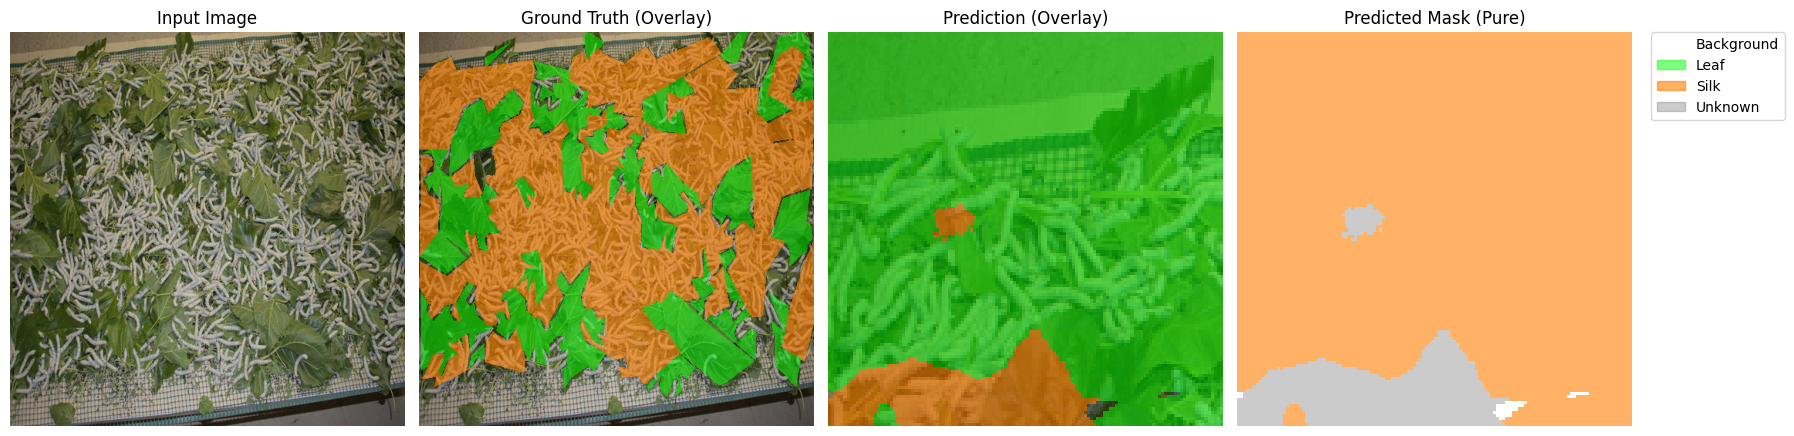

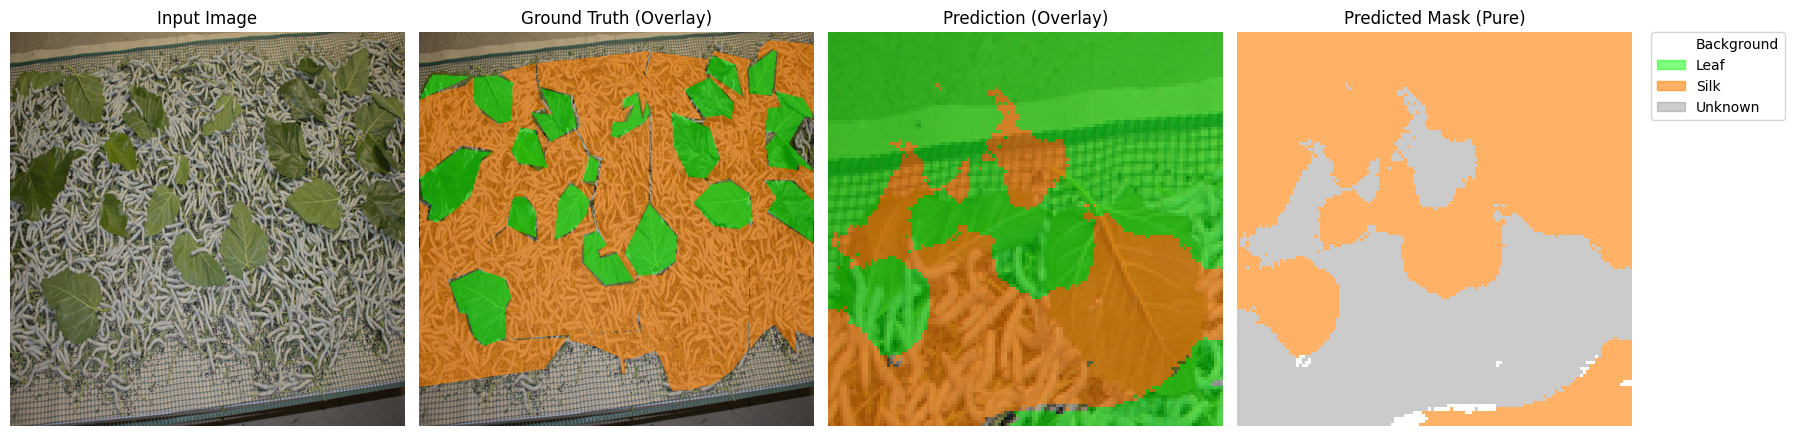

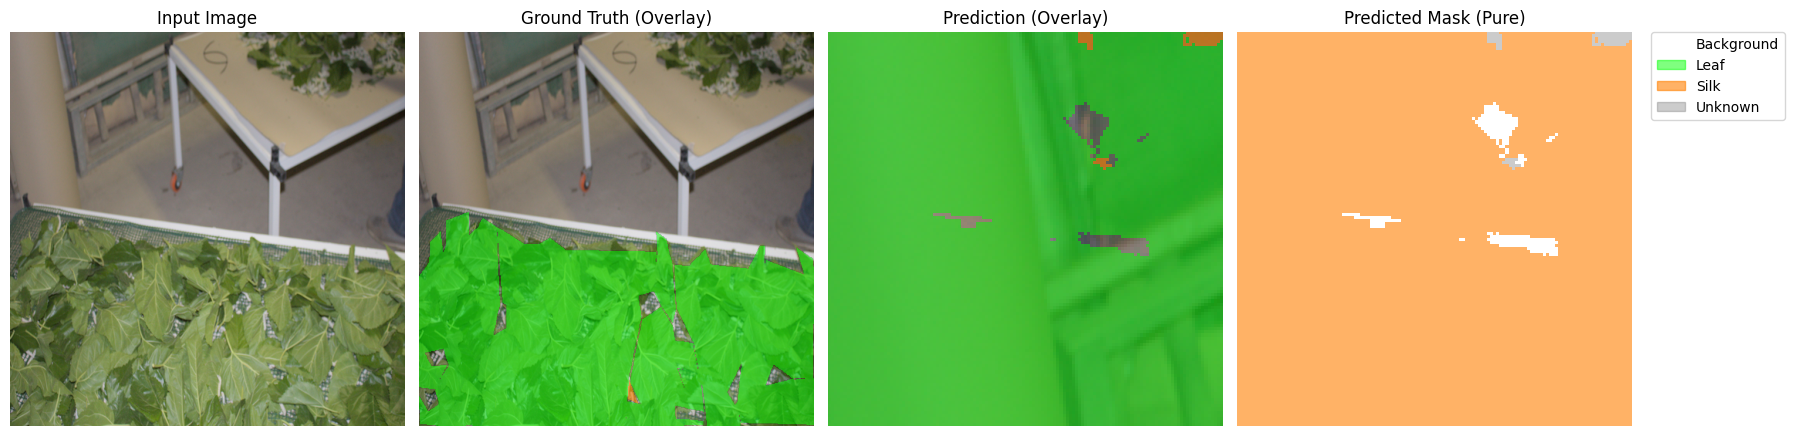

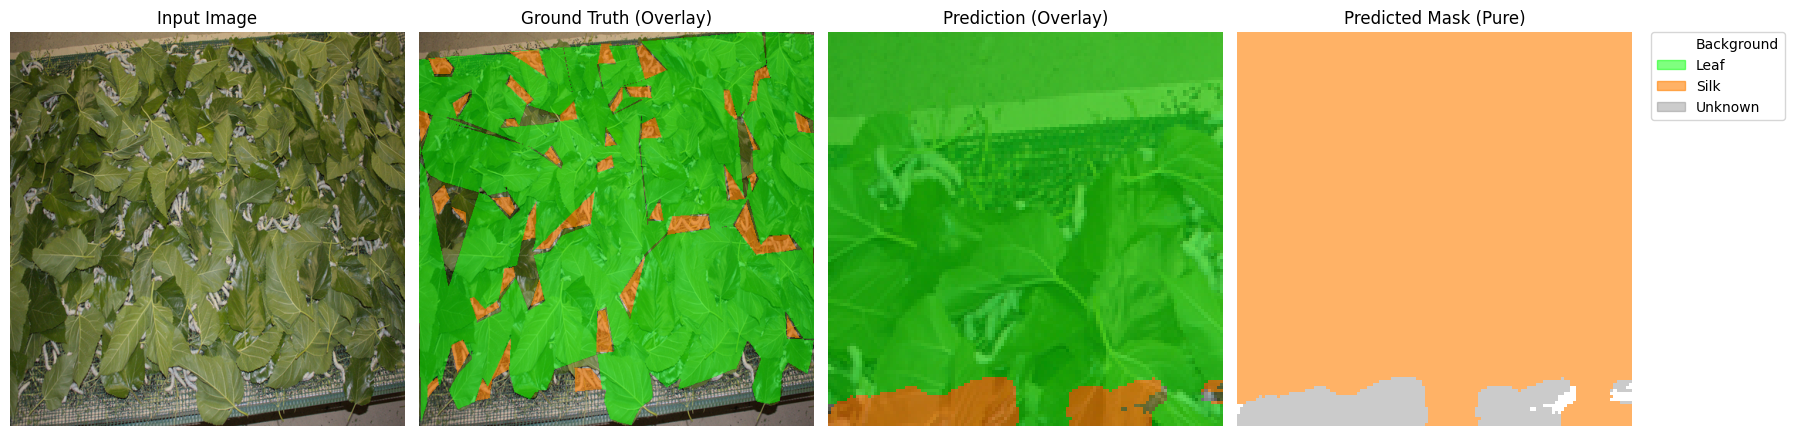


Images processed for inference: 4
Avg crop time      : 23.52 ms
Avg inference time : 13.98 ms
Avg total time     : 37.50 ms   |   ≈ 26.66 FPS


In [19]:
# --- 0. Initial Configuration and Paths ---
# Path to the root folder of your original dataset (where 0_data.csv is located)
IMAGES_SOURCE_DIR = '/kaggle/input/silk-dataset/silk_dataset'

# Path to the directory where your JSON-to-PNG converted masks are stored
# For example, if you ran the JSON conversion script and saved them here.
CONVERTED_MASKS_SOURCE_DIR = '/kaggle/working/output_masks_png'

# Path to the new root directory for the manually annotated mini-dataset (organized for SegFormer)
DATA_DIR = Path("/kaggle/working/my_segformer_mini_dataset")

# Folder for inference results
OUTPUT_INFERENCE_DIR = Path("/kaggle/working/segformer_inference_results_manual")
OUTPUT_INFERENCE_DIR.mkdir(exist_ok=True) # Create the directory if it doesn't exist


# --- Hyperparameters and Device Setup ---
IMG_SIZE = 512 # The target size (width and height) for images used in training and inference
BATCH_SIZE = 2 # Number of samples per batch. Adjusted for a small dataset.
ACC_STEPS = 1 # Gradient accumulation steps. Gradients are accumulated over this many batches before an optimizer step. (Set to 1 means no accumulation here)
EPOCHS = 100 # Total number of training epochs. More epochs for small datasets to ensure convergence.
LR = 5e-5 # Learning rate for the optimizer.
NUM_WORKERS = 0 # Number of subprocesses to use for data loading. 0 means data will be loaded in the main process (useful for small datasets to avoid multiprocessing overheads or issues).
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Automatically detect and use a GPU if available, otherwise fall back to CPU.
SEED = 42 # Random seed for reproducibility. Ensures that experiments can be replicated.
random.seed(SEED) # Seed Python's built-in random module.
torch.manual_seed(SEED) # Seed PyTorch's CPU operations.
torch.backends.cudnn.benchmark = True # This enables the cuDNN auto-tuner to find the best algorithms for your hardware, potentially speeding up training.

# --- Define Class IDs and Color Map (MUST MATCH YOUR MANUAL ANNOTATION) ---
# These mappings are critical for correctly interpreting mask pixel values and visualizing results.
# Ensure these match the exact RGB colors and class names you used in LabelMe and the JSON-to-PNG conversion script.
# MOVED TO GLOBAL SCOPE for easy access across functions.
CLASS_TO_ID_MAP_VISUALIZATION = {
    "background": 0,    # Class ID 0: (0, 0, 0) RGB in PNG masks (Typically black for background)
    "leaf": 1,          # Class ID 1: (0, 255, 0) RGB in PNG masks (Green for 'leaf')
    "silk": 2,          # Class ID 2: (255, 0, 0) RGB in PNG masks (Red for 'silk')
    "unknown": 3        # Class ID 3: (128, 128, 128) RGB in PNG masks (Gray for 'unknown'). Only include if you actually annotated this class.
}

# The total number of unique class IDs (e.g., if IDs are 0, 1, 2, 3, then N_CLASSES = 4).
# This value determines the output dimension of the segmentation model.
# MOVED TO GLOBAL SCOPE.
N_CLASSES = max(CLASS_TO_ID_MAP_VISUALIZATION.values()) + 1

# Custom Colors for Visualization - MOVED TO GLOBAL SCOPE
# These RGBA (Red, Green, Blue, Alpha) color values correspond to the integer IDs 0, 1, 2, 3.
# The alpha channel (last value) controls transparency (0.0 is fully transparent, 1.0 is fully opaque).
vis_custom_colors = [
    [0.0, 0.0, 0.0, 0.0],  # ID 0: Background (Transparent when overlaid)
    [0.0, 1.0, 0.0, 0.5],  # ID 1: Leaf (Green, semi-transparent)
    [1.0, 0.5, 0.0, 0.6],  # ID 2: Silk (Orange, slightly more opaque)
    [0.5, 0.5, 0.5, 0.4]   # ID 3: Unknown (Gray, semi-transparent, if used)
]
vis_custom_cmap = mcolors.ListedColormap(vis_custom_colors) # Create a Matplotlib colormap from the defined custom colors.

# Class Labels for the Legend - MOVED TO GLOBAL SCOPE
# This dictionary is used to display human-readable labels in the visualization legend.
CLASS_LABELS_FOR_LEGEND = {
    0: "Background", # Include background for inference visualization legend
    1: "Leaf",
    2: "Silk",
    3: "Unknown"
}

# Initialize the Image processor from Hugging Face Transformers.
# It handles image preprocessing steps like resizing and normalization required by the SegFormer model.
processor = SegformerImageProcessor(size=IMG_SIZE, reduce_labels=False) # reduce_labels=False prevents mapping labels to 0-num_labels-1 if they aren't already contiguous.

print(f"Number of classes for SegFormer: {N_CLASSES}")
print(f"Class to ID Map (for visualization/N_CLASSES): {CLASS_TO_ID_MAP_VISUALIZATION}")



## 1. Prepare Mini-Dataset Manually Annotated

# List of filenames for the images that you have manually annotated.
# !!! IMPORTANT: YOU MUST UPDATE THIS LIST WITH THE ACTUAL FILENAMES OF YOUR ANNOTATED IMAGES !!!
ANNOTATED_IMAGE_FILENAMES = [
    "IMG_3347.jpg",
    "IMG_2850.jpg",
    "IMG_3780.jpg",
    "IMG_3896.jpg",
    "IMG_4017.jpg",
    "IMG_2829.jpg",
    "IMG_2872.jpg",
    "IMG_3047.jpg",
    "IMG_4020.jpg",
    "IMG_3683.jpg",
    "IMG_3200.jpg"
]

# Percentage split for creating training and validation subsets from the annotated data.
TRAIN_SPLIT_RATIO = 0.65 # 65% of the annotated images will be used for training.
VAL_SPLIT_RATIO = 0.35   # 35% of the annotated images will be used for validation.

# Create the necessary dataset directory structure (images/train, masks/train, images/val, masks/val, etc.)
# This standardized structure is convenient for data loading.
for subdir_path in ['images/train', 'masks/train', 'images/val', 'masks/val', 'images/test', 'masks/test']:
    os.makedirs(DATA_DIR / subdir_path, exist_ok=True) # Use exist_ok=True to avoid errors if directories already exist.
print(f"Dataset directory structure created in: {DATA_DIR}")

# Shuffle the filenames to ensure a random distribution of images into training and validation sets.
random.shuffle(ANNOTATED_IMAGE_FILENAMES)

num_total_annotated = len(ANNOTATED_IMAGE_FILENAMES)
num_train_annotated = int(num_total_annotated * TRAIN_SPLIT_RATIO) # Calculate number of training images.

train_files_annotated = ANNOTATED_IMAGE_FILENAMES[:num_train_annotated] # Slice for training files.
val_files_annotated = ANNOTATED_IMAGE_FILENAMES[num_train_annotated:] # Remaining files go to validation.
test_files_annotated = [] # A separate test set is not used for this small sample, but the structure allows for it.

print(f"Splitting {num_total_annotated} annotated images: Train={len(train_files_annotated)}, Val={len(val_files_annotated)}")

def copy_annotated_files(file_list: List[str], split_type: str):
    """
    Copies image and mask files from their source directories to the designated
    train/val/test split directory within the structured dataset.

    Args:
        file_list (List[str]): A list of image filenames (e.g., "IMG_XXXX.jpg") to be copied.
        split_type (str): The type of dataset split ('train', 'val', or 'test') where files will be copied.
    """
    print(f"Copying files for {split_type} split...")
    # Use tqdm for a progress bar during file copying.
    for filename in tqdm(file_list, desc=f"Copying {split_type} files"):
        src_img_path = os.path.join(IMAGES_SOURCE_DIR, filename)
        # Assumes mask filenames are derived from original image filenames by appending '_mask.png'.
        src_mask_path = os.path.join(CONVERTED_MASKS_SOURCE_DIR, filename.replace(".jpg", "_mask.png"))

        dst_img_path = DATA_DIR / 'images' / split_type / filename # Destination path for the image.
        dst_mask_path = DATA_DIR / 'masks' / split_type / filename.replace(".jpg", "_mask.png") # Destination path for the mask.

        if os.path.exists(src_img_path) and os.path.exists(src_mask_path):
            shutil.copyfile(src_img_path, dst_img_path) # Copy the image file.
            shutil.copyfile(src_mask_path, dst_mask_path) # Copy the mask file.
        else:
            print(f"WARNING: File not found, skipping: {src_img_path} or {src_mask_path}. "
                  "Please ensure your ANNOTATED_IMAGE_FILENAMES list is correct and files exist.")

# Execute the file copying operation for the training and validation sets.
copy_annotated_files(train_files_annotated, 'train')
copy_annotated_files(val_files_annotated, 'val')
# The 'test_files_annotated' list is empty, so no files are copied for a separate test set in this configuration.


## 2. Data Loading Functions

#These functions define how image and mask data are loaded, preprocessed, and transformed into PyTorch tensors suitable for model training and evaluation.

def rgb_to_label(mask_image: Image.Image) -> torch.Tensor:
    """
    Converts a PIL Image mask (expected to be grayscale 'L' mode with integer IDs)
    into a PyTorch tensor of type torch.long, which is suitable for segmentation labels.
    It assumes that the pixel values directly represent the class IDs (e.g., 0, 1, 2, 3).
    """
    arr = np.array(mask_image.convert("L")) # CRUCIAL: Open the mask as 'L' (8-bit pixels, grayscale) to directly get integer ID values.

    # Optional: Basic check to warn if the mask contains pixel values that are not expected class IDs.
    # This can help in debugging issues with annotation or mask conversion.
    unique_pixel_values = np.unique(arr)
    expected_ids = set(range(N_CLASSES))
    if not np.all(np.isin(unique_pixel_values, list(expected_ids))):
        print(f"WARNING: Mask contains unexpected pixel values: {unique_pixel_values}. Expected IDs: {list(expected_ids)}.")
        print("This might indicate annotation errors or issues in JSON-to-PNG conversion. Training may be affected.")

    return torch.as_tensor(arr, dtype=torch.long) # Convert the NumPy array to a PyTorch Long tensor.

def rand_crop(img: Image.Image, mask: Image.Image, size: int):
    """
    Performs a random crop on both the input image and its corresponding mask.
    If the mask contains foreground objects (pixels with ID > 0), the crop is biased
    to be centered around these objects to ensure they are present in the cropped region.
    Otherwise, a purely random crop is performed.
    This function remains useful for data augmentation even with a small dataset.
    """
    if img.width == size and img.height == size:
        return img, mask # If the image is already the target size, no cropping is needed.

    m = np.array(mask.convert("L")) # Convert the mask PIL Image to a NumPy array (grayscale).
    ys, xs = np.where(m > 0) # Find the (y, x) coordinates of non-background pixels (i.e., objects).

    if xs.size: # If there are foreground objects found in the mask:
        cx, cy = int(xs.mean()), int(ys.mean()) # Calculate the mean (center) coordinates of the objects.
        # Determine the top-left corner (left, top) of the crop, ensuring it stays within image boundaries.
        left = max(0, min(cx - size // 2, img.width - size))
        top = max(0, min(cy - size // 2, img.height - size))
    else: # If no foreground objects are found in the mask:
        left = random.randint(0, img.width - size) # Randomly select left coordinate.
        top = random.randint(0, img.height - size) # Randomly select top coordinate.

    return TF.crop(img, top, left, size, size), TF.crop(mask, top, left, size, size) # Perform the crop using torchvision.transforms.functional.

def load_pairs(split: str) -> List[Tuple[str, str]]:
    """
    Scans the specified directories for a given dataset split ('train', 'val', 'test')
    and creates a list of (image_path, mask_path) tuples.
    It expects mask filenames to be derived from original image filenames (e.g., 'image_name_mask.png').
    """
    masks_dir = DATA_DIR / 'masks' / split # Path to the masks directory for the current split.
    images_dir = DATA_DIR / 'images' / split # Path to the images directory for the current split.

    masks = sorted(list(masks_dir.glob("*_mask.png"))) # Find all PNG mask files in the directory, sorted by name.

    pairs = []
    for mask_p in masks:
        original_filename_stem = mask_p.stem.replace("_mask", "") # Extract the base filename (without '_mask.png').
        original_image_name = f"{original_filename_stem}.jpg" # Reconstruct the expected original image filename.
        img_p = images_dir / original_image_name # Construct the full path to the corresponding image.

        if img_p.exists(): # Check if the corresponding image file exists.
            pairs.append((str(img_p), str(mask_p))) # Add the (image_path, mask_path) tuple to the list.
        else:
            print(f"Warning: Original image not found for mask {mask_p}. Skipping.") # Warn if a mask has no matching image.
    return pairs # Return the list of image-mask path pairs.

class SegDataset(Dataset):
    """
    A custom PyTorch Dataset class for semantic segmentation.
    It handles loading image-mask pairs, applying transformations (cropping, flipping, color jitter),
    and preparing them into tensors for the SegFormer model.
    """
    def __init__(self, split: str):
        self.pairs = load_pairs(split) # Load all image and mask file path pairs for this split.
        self.split = split # Store the dataset split type ('train' or 'val').
        # Initialize ColorJitter for data augmentation only if it's the training split.
        self.jitter = T.ColorJitter(0.3, 0.3, 0.3, 0.1) if split == "train" else None
        print(f"Loaded {len(self.pairs)} pairs for split {split}.")

    def __len__(self):
        return len(self.pairs) # Returns the total number of samples (image-mask pairs) in the dataset.

    def __getitem__(self, idx: int):
        """
        Retrieves an image and its corresponding mask by index, applies necessary
        transformations, and returns the processed pixel values and label tensor.
        """
        img_p, mask_p = self.pairs[idx] # Get the file paths for the current index.
        img = Image.open(img_p).convert("RGB") # Open the image and convert it to RGB format.
        mask = Image.open(mask_p).convert("L") # CRUCIAL: Open the mask as 'L' (grayscale) to get integer class IDs.

        img, mask = rand_crop(img, mask, IMG_SIZE) # Apply random cropping to both image and mask.

        if self.split == "train": # Apply additional data augmentations only for the training set.
            if random.random() < 0.5: # Apply random horizontal flip with 50% probability.
                img, mask = TF.hflip(img), TF.hflip(mask)
            if self.jitter: # Apply color jitter if it was initialized (i.e., for training).
                img = self.jitter(img)

        # Process the image's pixel values using the SegFormer processor.
        # This handles resizing, normalization, and converting the image to a PyTorch tensor.
        pv = processor(images=img, return_tensors="pt").pixel_values.squeeze(0)
        lab = rgb_to_label(mask) # Convert the mask PIL Image to a PyTorch label tensor.
        return pv, lab # Return the processed pixel values and the label tensor.

def make_loader(split: str):
    """
    Creates a PyTorch DataLoader for a given dataset split ('train' or 'val').
    DataLoaders handle batching, shuffling, and multi-threaded data loading.
    """
    dataset = SegDataset(split) # Instantiate the custom SegDataset.
    # Check if the dataset is empty for the split before creating a DataLoader to avoid errors.
    if len(dataset) == 0:
        print(f"Warning: DataLoader for '{split}' is empty. mIoU calculation might be affected.")
        return None # Return None if the dataset is empty.
    # Create and return the DataLoader. Shuffling is enabled only for the training split.
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=(split == "train"),
                      num_workers=NUM_WORKERS, pin_memory=True) # pin_memory can speed up data transfer to GPU.

# Create the training and validation DataLoaders.
train_loader = make_loader("train")
val_loader = make_loader("val")


# --- 3. SegFormer Model Initialization ---
# Initializes the SegFormer model for semantic segmentation.
# It loads a pre-trained checkpoint and configures the model for the specific number of classes in your dataset.
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512", # Specifies the pre-trained SegFormer model (base-0, fine-tuned on ADE20K).
    num_labels=N_CLASSES, # Sets the number of output classes for the final segmentation head to match your dataset.
    ignore_mismatched_sizes=True # Allows loading the pre-trained model even if the classification head's size doesn't perfectly match N_CLASSES initially; it will be reinitialized.
).to(DEVICE) # Move the entire model to the specified device (GPU or CPU).


# --- 4. Optimizer and Scheduler ---
# Configures the optimizer for updating model weights during training and a learning rate scheduler
# to control how the learning rate changes over the course of training.
optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4) # Initialize the AdamW optimizer with a specified learning rate and weight decay.

# Calculate the total number of training steps for the learning rate scheduler.
# This ensures the scheduler can properly scale the learning rate over the entire training duration.
steps_total = EPOCHS * len(train_loader) // ACC_STEPS if train_loader else 0
# Initialize a cosine annealing learning rate scheduler with no warmup steps.
# The learning rate will gradually decrease following a cosine curve throughout training.
sched = get_cosine_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=steps_total)
# Initialize a gradient scaler for mixed-precision training (Automatic Mixed Precision - AMP).
# This is enabled if a CUDA-capable GPU is available, speeding up training and reducing memory usage.
scaler = torch.amp.GradScaler(enabled=DEVICE.type == "cuda")
# Define the autocast context manager for automatic mixed precision.
autocast = torch.amp.autocast

# --- 5. Training and Evaluation Functions ---
# These functions encapsulate the core logic for training one epoch and evaluating the model's performance.

def train_epoch(ep: int):
    """
    Performs one full epoch of training over the training dataset.

    Args:
        ep (int): The current epoch number.

    Returns:
        float: The average training loss for the completed epoch.
    """
    model.train() # Set the model to training mode. This enables dropout and batch normalization updates.
    tot = 0.0 # Initialize a variable to accumulate the total loss for the epoch.

    if not train_loader: # Check if the training data loader is empty.
        print("Error: Train_loader is empty. Cannot perform training.")
        return 0.0 # Return 0.0 loss if no training data is available.

    # Initialize a tqdm progress bar for visual feedback during the epoch.
    prog = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {ep}", leave=False)
    optim.zero_grad(set_to_none=True) # Clear any previously computed gradients from the optimizer.

    for i, (pix, lab) in prog:
        pix, lab = pix.to(DEVICE), lab.to(DEVICE) # Move the input pixel values and labels to the designated device (GPU/CPU).
        # Use autocast for mixed-precision training if a CUDA device is available.
        with autocast(device_type="cuda", enabled=DEVICE.type == "cuda", dtype=torch.float16):
            # Forward pass: compute model output and the loss.
            # Loss is divided by ACC_STEPS to average it correctly when accumulating gradients.
            loss = model(pixel_values=pix, labels=lab).loss / ACC_STEPS
        scaler.scale(loss).backward() # Scale the loss and perform backward propagation to compute gradients.
        tot += loss.item() * ACC_STEPS # Accumulate the original (un-divided) loss for reporting.

        if (i + 1) % ACC_STEPS == 0: # Check if enough batches have passed for a gradient accumulation step.
            scaler.step(optim) # Update the model's weights using the optimizer.
            scaler.update() # Update the state of the gradient scaler.
            sched.step() # Update the learning rate according to the scheduler.
            optim.zero_grad(set_to_none=True) # Clear gradients for the next accumulation cycle.
        prog.set_postfix(loss=f"{tot / (i + 1):.4f}") # Update the progress bar with the current average loss.

    return tot / len(train_loader) # Return the average training loss for the entire epoch.

@torch.no_grad() # Decorator that ensures no gradients are computed within this function, optimizing memory and speed for inference/evaluation.
def evaluate():

    if not val_loader: # Check if the validation data loader is empty.
        print("Warning: Val_loader is empty, cannot calculate mIoU.")
        return 0.0 # Return 0.0 mIoU if no validation data is available.

    model.eval() # Set the model to evaluation mode. This disables dropout and fixes batch normalization layers.
    conf = torch.zeros((N_CLASSES, N_CLASSES), dtype=torch.int64) # Initialize a confusion matrix of size N_CLASSES x N_CLASSES.

    for pix, lab in val_loader:
        pix, lab = pix.to(DEVICE), lab.to(DEVICE) # Move the input pixel values and ground truth labels to the device.
        with autocast(device_type="cuda", enabled=DEVICE.type == "cuda", dtype=torch.float16):
            logits = model(pixel_values=pix).logits # Perform a forward pass to get the model's raw output (logits).
        # Upsample the logits to match the original label size using bilinear interpolation.
        logits = F.interpolate(logits, size=lab.shape[-2:], mode="bilinear", align_corners=False)
        pred = torch.argmax(logits, 1) # Get the predicted class ID for each pixel by taking the argmax over the channel dimension.

        lab_flat = lab.view(-1).cpu() # Flatten the ground truth labels into a 1D tensor and move to CPU.
        pred_flat = pred.view(-1).cpu() # Flatten the predicted labels into a 1D tensor and move to CPU.
        # Populate the confusion matrix: increment count for each (true_label, predicted_label) pair.
        conf.index_put_((lab_flat, pred_flat), torch.ones_like(lab_flat), accumulate=True)

    # Calculate mIoU (Mean Intersection over Union) only for classes that are actually present in the ground truth.
    # This avoids issues with undefined IoU for classes that have no ground truth pixels.
    valid_classes_in_gt = (conf.sum(1) > 0) # Boolean mask indicating which classes have non-zero sum in ground truth.
    if valid_classes_in_gt.sum() > 0: # Proceed only if there's at least one valid class to calculate IoU for.
        # Calculate IoU for each class: Intersection / (Union) = True Positives / (False Positives + False Negatives + True Positives)
        iu = torch.diag(conf) / (conf.sum(1) + conf.sum(0) - torch.diag(conf) + 1e-6) # Add a small epsilon to prevent division by zero.
        return iu[valid_classes_in_gt].mean().item() # Return the mean IoU of only the valid classes.
    else:
        return 0.0 # Return 0.0 if no valid classes were found in the ground truth for IoU calculation.

# --- 6. Training Loop ---
# This is the main loop that orchestrates the entire training process across multiple epochs.

best = 0. # Initialize 'best' variable to keep track of the highest mIoU achieved so far.
print(f"Starting training for {EPOCHS} epochs...")

if train_loader: # Proceed with training only if a training data loader is successfully created.
    for ep in range(1, EPOCHS + 1): # Loop through each epoch, starting from 1.
        train_loss = train_epoch(ep) # Execute one training epoch and get the average training loss.
        miou = evaluate() # Evaluate the model's performance on the validation set and get the mIoU.
        print(f"Epoch {ep}: loss {train_loss:.4f} | mIoU {miou * 100:.2f}%") # Print epoch summary.

        # Save the model's state dictionary if the mIoU improves, or periodically.
        if miou > best: # If current mIoU is better than the best recorded mIoU:
            best = miou # Update the best mIoU.
            torch.save(model.state_dict(), "segformer_b0_best_mini_dataset.pth") # Save the model's weights.
            print("Saved best model (based on mIoU).")
        elif ep % 10 == 0: # Also save a snapshot of the model every 10 epochs.
            torch.save(model.state_dict(), f"segformer_b0_mini_dataset_epoch_{ep}.pth")
            print(f"Saved model after Epoch {ep}.")
else:
    print("No training data found. Cannot train.") # Inform the user if training cannot proceed due to no data.



## 7. Inference on Test Set and Visualization

#This section loads the best-performing trained model and performs inference on a subset of images, then visualizes the original input, the ground truth mask, and the model's predicted segmentation mask.

# For this setup, we'll perform inference on images from the validation set.
N_PRED_VISUALIZE = 5 # Defines how many random images from the inference set will be visualized.
out_dir = Path("/kaggle/working/segformer_inference_results_mini_dataset") # Directory to save visualization results.
out_dir.mkdir(exist_ok=True) # Create the output directory if it doesn't exist.

# Load the best model (if it was saved during training).
model_path_to_load = "segformer_b0_best_mini_dataset.pth"
if os.path.exists(model_path_to_load):
    model.load_state_dict(torch.load(model_path_to_load, map_location=DEVICE)) # Load the saved model weights.
    model.eval() # Set the model to evaluation mode for inference.
else:
    print(f"Trained model not found at {model_path_to_load}. Cannot perform inference.")
    exit() # Exit the script if the model weights cannot be found.

test_pairs_for_inference = []
if val_loader:
    test_pairs_for_inference = val_loader.dataset.pairs # Use the validation set's pairs for inference.
elif train_loader: # As a fallback, if no validation set is defined, use the training set for inference.
    test_pairs_for_inference = train_loader.dataset.pairs

if not test_pairs_for_inference:
    print("No images found for inference.")
    exit() # Exit if there are no images available for inference.

# Ensure that the number of images to visualize does not exceed the available images.
N_PRED_VISUALIZE = min(N_PRED_VISUALIZE, len(test_pairs_for_inference))
# Select a random sample of images from the inference set for visualization.
test_pairs_for_inference = random.sample(test_pairs_for_inference, N_PRED_VISUALIZE)

t_crop, t_inf = [], [] # Lists to store the time taken for image cropping/resizing and model inference.
shown = 0 # Counter for the number of images visualized.

print(f"\nPerforming inference and visualization on {len(test_pairs_for_inference)} images...")
with torch.no_grad(): # Disable gradient calculations for inference to save memory and speed.
    for img_p_orig, mask_p_orig in tqdm(test_pairs_for_inference, desc="SegFormer Inference"):
        t0 = time.perf_counter() # Record the start time for the current image processing.

        img = Image.open(img_p_orig).convert("RGB") # Load the original image and ensure it's in RGB format.
        mask_gt = Image.open(mask_p_orig).convert("L") # Load the Ground Truth mask as a grayscale (L) image.

        t_c0 = time.perf_counter() # Record start time for cropping/resizing.
        if img.width != IMG_SIZE or img.height != IMG_SIZE:
            # Resize the input image to the required IMG_SIZE using LANCZOS filter for high quality.
            img_processed_for_inference = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
        else:
            img_processed_for_inference = img # If already at size, use as is.
        t_c1 = time.perf_counter() # Record end time for cropping/resizing.

        # Prepare the processed image for the model using the SegFormer processor.
        pv = processor(images=img_processed_for_inference, return_tensors="pt").pixel_values.to(DEVICE)
        t_i0 = time.perf_counter() # Record start time for model inference.
        with autocast(device_type="cuda", enabled=DEVICE.type == "cuda", dtype=torch.float16):
            logits = model(pixel_values=pv).logits # Perform the forward pass to get logits.
        t_i1 = time.perf_counter() # Record end time for model inference.

        # Convert the model's raw logits into a predicted segmentation mask (class IDs).
        pred_mask_tensor = torch.argmax(logits, 1).squeeze(0).cpu() # Get the index of the max logit (class ID).
        mask_np = pred_mask_tensor.numpy().astype(np.uint8) # Convert to a NumPy array of unsigned 8-bit integers.

        # For comparison, resize the Ground Truth mask to IMG_SIZE using nearest-neighbor interpolation (suitable for masks).
        mask_gt_np_resized = np.array(mask_gt.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))

        # Apply the custom colormap to both the predicted and ground truth masks for visual representation.
        colour_map_applied_pred = vis_custom_cmap(mask_np)
        colour_map_applied_gt = vis_custom_cmap(mask_gt_np_resized)

        # Save the pure predicted mask (as integer IDs) to the output directory.
        output_filename_pred = Path(img_p_orig).stem + "_segformer_pred.png"
        Image.fromarray(mask_np).save(out_dir / output_filename_pred)

        # --- Visualization ---
        plt.figure(figsize=(18, 6)) # Create a Matplotlib figure for plotting, adjusted for 4 subplots.

        # Subplot 1: Display the Input Image
        ax1 = plt.subplot(1, 4, 1) # (rows, columns, plot_number)
        ax1.imshow(img_processed_for_inference)
        ax1.set_title("Input Image")
        ax1.axis("off") # Turn off axis labels and ticks for a cleaner look.

        # Subplot 2: Display the Ground Truth Mask Overlayed on the Input Image
        ax2 = plt.subplot(1, 4, 2)
        ax2.imshow(img_processed_for_inference) # Show the original image as the background.
        ax2.imshow(colour_map_applied_gt) # Overlay the ground truth mask using the custom colormap (with transparency).
        ax2.set_title("Ground Truth (Overlay)")
        ax2.axis("off")

        # Subplot 3: Display the Predicted Mask Overlayed on the Input Image
        ax3 = plt.subplot(1, 4, 3)
        ax3.imshow(img_processed_for_inference) # Show the original image as the background.
        ax3.imshow(colour_map_applied_pred) # Overlay the predicted mask using the custom colormap (with transparency).
        ax3.set_title("Prediction (Overlay)")
        ax3.axis("off")

        # Subplot 4: Display the Pure Predicted Mask with a Legend
        ax4 = plt.subplot(1, 4, 4)
        ax4.imshow(mask_np, cmap=vis_custom_cmap, interpolation="nearest") # Display the pure predicted mask.
        ax4.set_title("Predicted Mask (Pure)")
        ax4.axis("off")
        # Add a legend that maps the colors in the mask to their corresponding class labels.
        ax4.legend(handles=[mpatches.Patch(color=vis_custom_colors[i], label=CLASS_LABELS_FOR_LEGEND[i])
                            for i in sorted(CLASS_LABELS_FOR_LEGEND.keys())], # Create patches for each class.
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Position the legend outside the plot.

        plt.tight_layout() # Adjust subplot parameters for a tight layout, preventing labels/titles from overlapping.
        plt.show() # Display the generated plot.
        shown += 1 # Increment the count of shown visualizations.

        # Append the measured times for cropping and inference to their respective lists.
        t_crop.append(t_c1 - t_c0)
        t_inf.append(t_i1 - t_i0)

# Calculate and print the average times for cropping, inference, and total processing.
avg_crop = statistics.mean(t_crop)
avg_inf = statistics.mean(t_inf)
num_imgs = len(test_pairs_for_inference)
print(f"\nImages processed for inference: {num_imgs}")
print(f"Avg crop time      : {avg_crop * 1e3:.2f} ms") # Average crop time in milliseconds.
print(f"Avg inference time : {avg_inf * 1e3:.2f} ms") # Average inference time in milliseconds.
print(f"Avg total time     : {(avg_crop + avg_inf) * 1e3:.2f} ms   |   ≈ {1 / (avg_crop + avg_inf):.2f} FPS") # Average total time and approximate Frames Per Second.

In [21]:
GENERATED_MASKS_DIR = '/kaggle/working/segformer_inference_results_mini_dataset'
ZIP_FILE_PATH = '/kaggle/working/labelme_generated_masks.zip'

print(f"Zippando la cartella: {GENERATED_MASKS_DIR} in {ZIP_FILE_PATH}...")

# Esegui il comando zip
# -r: ricorsivo (include tutte le sottocartelle e i file)
# {SAM_ZIP_FILE_PATH}: il nome del file zip di output
# {SAM_GENERATED_MASKS_DIR}: la cartella da zippare
!zip -r {ZIP_FILE_PATH} {GENERATED_MASKS_DIR}

print("Zippatura completata!")
print(f"Il file ZIP '{ZIP_FILE_PATH}' è stato creato.")

Zippando la cartella: /kaggle/working/segformer_inference_results_mini_dataset in /kaggle/working/labelme_generated_masks.zip...
updating: kaggle/working/segformer_inference_results_mini_dataset/ (stored 0%)
updating: kaggle/working/segformer_inference_results_mini_dataset/IMG_2850_segformer_pred.png (deflated 6%)
updating: kaggle/working/segformer_inference_results_mini_dataset/IMG_3347_segformer_pred.png (deflated 6%)
updating: kaggle/working/segformer_inference_results_mini_dataset/IMG_3200_segformer_pred.png (stored 0%)
updating: kaggle/working/segformer_inference_results_mini_dataset/IMG_4017_segformer_pred.png (deflated 15%)
Zippatura completata!
Il file ZIP '/kaggle/working/labelme_generated_masks.zip' è stato creato.
